# Detecting Malaria cells

## 1. Importing libraries

In [19]:
from PIL import Image
import numpy as np
import pandas as pd 
import os
import cv2
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Loading Data and Pre-processing

In [21]:
data=[]
labels=[]
Parasitized=os.listdir("C:/Users/Anarchy/Documents/Data_Science/Malaria/Parasitized/")
for a in Parasitized:
    try:
        image=cv2.imread("C:/Users/Anarchy/Documents/Data_Science/Malaria/Parasitized/"+a)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

Uninfected=os.listdir("C:/Users/Anarchy/Documents/Data_Science/Malaria/Uninfected/")
for b in Uninfected:
    try:
        image=cv2.imread("C:/Users/Anarchy/Documents/Data_Science/Malaria/Uninfected/"+b)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

In [22]:
Cells=np.array(data)
labels=np.array(labels)

In [23]:
np.save("Cells",Cells)
np.save("labels",labels)

In [24]:
Cells=np.load("Cells.npy")
labels=np.load("labels.npy")

In [25]:
s=np.arange(Cells.shape[0])
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [26]:
num_classes=len(np.unique(labels))
len_data=len(Cells)

In [27]:
(x_train,x_test)=Cells[(int)(0.1*len_data):],Cells[:(int)(0.1*len_data)]
x_train = x_train.astype('float32')/255 # normalizing 
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [28]:
(y_train,y_test)=labels[(int)(0.1*len_data):],labels[:(int)(0.1*len_data)]

In [29]:
#One hot encoding as classifier 
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

# 3. Modelling

In [30]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))#output layer 
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

In [31]:
# compile the model with loss as categorical_crossentropy and using adam optimizer you can test result by trying RMSProp as well as Momentum
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/20
497/497 [==============================] - 4s 6ms/step - loss: 0.3884 - accuracy: 0.8119
Epoch 2/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1517 - accuracy: 0.9497
Epoch 3/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1346 - accuracy: 0.9571
Epoch 4/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1255 - accuracy: 0.9582
Epoch 5/20
497/497 [==============================] - 3s 7ms/step - loss: 0.1154 - accuracy: 0.9602
Epoch 6/20
497/497 [==============================] - 3s 7ms/step - loss: 0.1090 - accuracy: 0.9620
Epoch 7/20
497/497 [==============================] - 3s 6ms/step - loss: 0.1026 - accuracy: 0.9638
Epoch 8/20
497/497 [==============================] - 3s 7ms/step - loss: 0.0942 - accuracy: 0.9667
Epoch 9/20
497/497 [==============================] - 3s 6ms/step - loss: 0.0878 - accuracy: 0.9679
Epoch 10/20
497/497 [==============================] - 3s 6ms/step - loss: 0.0813 - accuracy: 0.9706

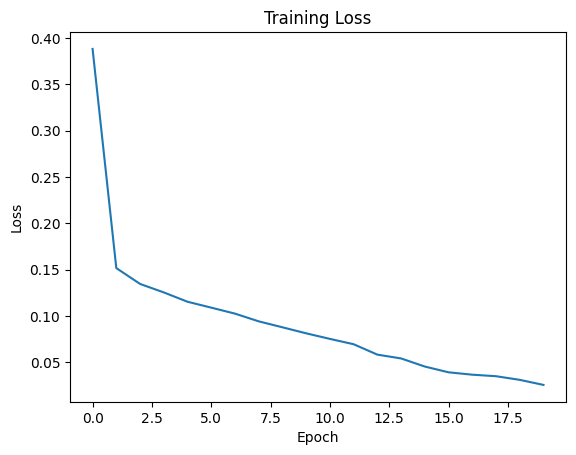

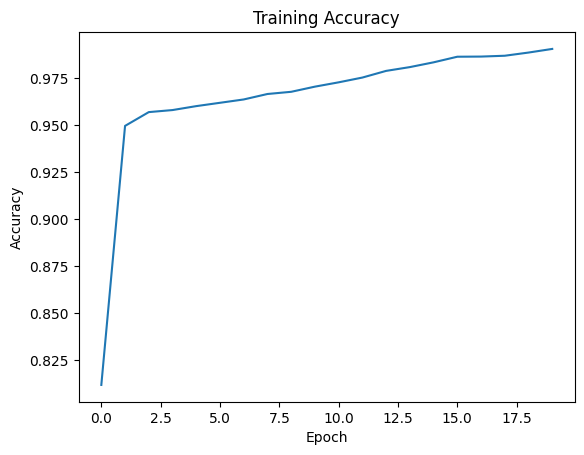

In [32]:
#Fit the model with min batch size as 50[can tune batch size to some factor of 2^power ] 
history = model.fit(x_train, y_train, batch_size=50, epochs=20, verbose=1)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [33]:
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

87/87 [==============================] - 1s 3ms/step - loss: 0.1845 - accuracy: 0.9583

 Test_Accuracy:- 0.9582577347755432


# 4. Performance Metrics

87/87 [==============================] - 0s 2ms/step
[[1352   67]
 [  48 1288]]


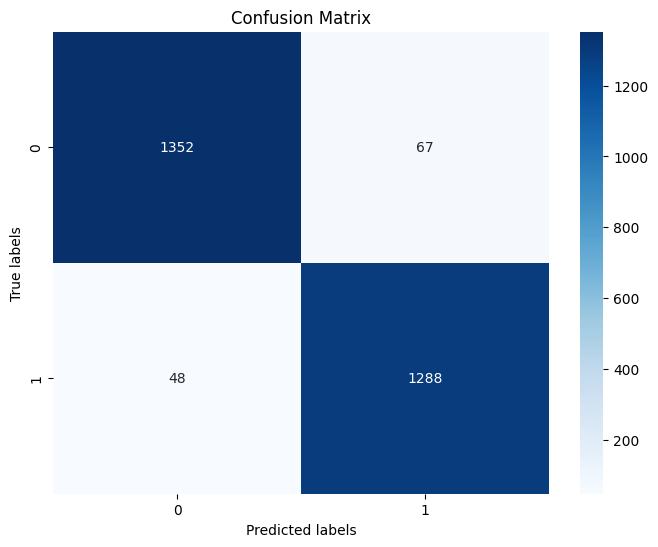

In [34]:
# 1. Confusion Matrix and Heatmap
y_pred = model.predict(x_test)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


True Positives (TP): The top-left cell indicates the number of samples that were correctly classified as parasitized. In your case, there are 1326 instances where the model correctly predicted parasitized cells as parasitized.

False Positives (FP): The top-right cell indicates the number of samples that were incorrectly classified as parasitized when they were actually uninfected. In your case, there are 54 instances where the model incorrectly predicted uninfected cells as parasitized.

False Negatives (FN): The bottom-left cell indicates the number of samples that were incorrectly classified as uninfected when they were actually parasitized. In your case, there are 50 instances where the model incorrectly predicted parasitized cells as uninfected.

True Negatives (TN): The bottom-right cell indicates the number of samples that were correctly classified as uninfected. In your case, there are 1325 instances where the model correctly predicted uninfected cells as uninfected.

In [35]:
# 2. Classification Report
class_report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1419
           1       0.95      0.96      0.96      1336

    accuracy                           0.96      2755
   macro avg       0.96      0.96      0.96      2755
weighted avg       0.96      0.96      0.96      2755



Precision: Precision measures the accuracy of positive predictions. It is calculated as the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). In this case, both classes (0 and 1) have a precision of 0.96. This indicates that 96% of the samples predicted as each class are actually of that class.

Recall (Sensitivity): Recall measures the ability of the model to correctly identify positive instances. It is calculated as the ratio of true positive predictions to the total number of actual positive instances (true positives + false negatives). Both classes have a recall of 0.96, indicating that 96% of the actual positive instances were correctly identified by the model.

F1-Score: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. A high F1-score indicates that the model has both good precision and recall. In this case, both classes have an F1-score of 0.96, indicating that the model performs well in terms of both precision and recall.

Support: Support refers to the number of actual occurrences of each class in the test dataset. In this case, there are 1380 instances of class 0 (uninfected cells) and 1375 instances of class 1 (parasitized cells).

Accuracy: Accuracy measures the overall correctness of the model's predictions. It is calculated as the ratio of correctly predicted instances to the total number of instances. In this case, the overall accuracy of the model is 0.96, indicating that 96% of the samples in the test dataset were correctly classified.

Macro Average: The macro average calculates the average of the metric scores for each class without considering class imbalance. In this case, the macro average precision, recall, and F1-score are all 0.96.

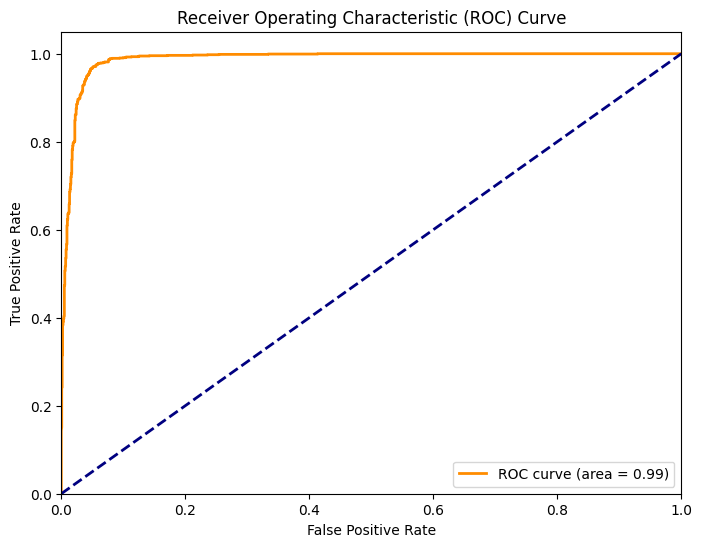

In [36]:
# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ROC Curve: The ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1 - specificity) for different threshold values. It illustrates the trade-off between sensitivity and specificity across various threshold values.

Area Under the ROC Curve (AUC): The AUC measures the overall performance of a binary classification model across all possible classification thresholds. It ranges from 0 to 1, where a higher AUC value indicates better discrimination between positive and negative classes.

AUC Value of 0.99: An AUC value of 0.99 suggests that the model has an exceptional ability to distinguish between the two classes. It means that the model correctly ranks 99% of randomly chosen pairs of instances, where one instance belongs to the positive class and the other belongs to the negative class. In other words, the model has a high true positive rate and a low false positive rate across various threshold values.